In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input, Dropout

# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files we will see it later
import librosa
import librosa.display

# to play the audio files
import IPython.display as ipd
from IPython.core.display import display

from tqdm.notebook import tqdm

In [8]:
##############################################################################
# WE CREATE THE BIG DATASET FIRST CONTAINING THE FILE PATHS AND THEIR LABELS #
##############################################################################

# datasets paths on the machine
CREMA = "data/CREMA-D"
RAVDESS = "data/RAVDESS"
SAVEE = "data/SAVEE"
TESS = "data/TESS"

paths_df = pd.DataFrame(columns=['gender', 'path', 'emotion'])

In [43]:
# Labels Names
ANGRY = "angry"
DISGUST = "disgust"
FEAR = "fear"
HAPPY = "happy"
NEUTRAL = "neutral"
SAD = "sad"
SURPRISE = "surprise"

# paths to saved states
paths_and_labels_state_path = 'states/paths_and_labels.csv'

In [6]:
# CREMA dataset
CREMA_FILES = os.listdir(CREMA)

female_file_numbers = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

# loop over the files in CREMA dataset, storing their paths, gender and labels
for index, file in tqdm(enumerate(CREMA_FILES)):
    label = file.split("_")[2]
    file_number = int(file.split("_")[0])
     
    if label == 'SAD':
        emotion = SAD
    elif label == 'ANG':
        emotion = ANGRY
    elif label == 'DIS':
        emotion = DISGUST
    elif label == 'FEA':
        emotion = FEAR
    elif label == 'HAP':
        emotion = HAPPY
    elif label == 'NEU':
        emotion = NEUTRAL
    else:
        emotion = 'unknown'
    
    gender = 'female' if file_number in female_file_numbers else 'male'
    path = os.path.join(CREMA, file)
    
    paths_df.loc[index] = [gender, path, emotion]

paths_df.head()

,gender,path,emotion
0,male,data/CREMA-D\1001_DFA_ANG_XX.wav,angry
1,male,data/CREMA-D\1001_DFA_DIS_XX.wav,disgust
2,male,data/CREMA-D\1001_DFA_FEA_XX.wav,fear
3,male,data/CREMA-D\1001_DFA_HAP_XX.wav,happy
4,male,data/CREMA-D\1001_DFA_NEU_XX.wav,neutral


In [16]:
# RAVDESS dataset

# adjust the index
index += 1

for dirname, _, filenames in tqdm(os.walk(RAVDESS)):
    for filename in filenames:
        # filename contains set of labels in the following form: 03-01-01-01-01-01-01.wav
        # naming conventions can be found in this link: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

        label = filename.split('-')[2]
        if label == '01':
            emotion = NEUTRAL
        elif label == '02':
            continue # not found in others
        elif label == '03':
            emotion = HAPPY
        elif label == '04':
            emotion = SAD
        elif label == '05':
            emotion = ANGRY
        elif label == '06':
            emotion = FEAR
        elif label == '07':
            emotion = DISGUST
        elif label == '08':
            emotion = SURPRISE
        else:
            emotion = 'unknown'
            
        actor_number = int(filename.split('-')[-1][:2])
        gender = 'female' if actor_number % 2 == 0 else 'male'
        
        path = os.path.join(dirname, filename)
        
        paths_df.loc[index] = [gender, path, emotion]
        index += 1

In [33]:
# SAVEE dataset
SAVEE_FILES = os.listdir(SAVEE)
for savee_index, file in tqdm(enumerate(SAVEE_FILES)):
    
    if file[-7] == 'a':
        emotion = ANGRY
    elif file[-7] == 'd':
        emotion = DISGUST
    elif file[-7] == 'f':
        emotion = FEAR
    elif file[-7] == 'h':
        emotion = HAPPY
    elif file[-7] == 'n':
        emotion = NEUTRAL
    elif file[-8: -6] == 'sa':
        emotion = SAD
    elif file[-8: -6] == 'su':
        emotion = SURPRISE
    else:
        emotion = 'unknown'
    
    gender = 'male'
    path = os.path.join(SAVEE, file)
    
    paths_df.loc[index + savee_index] = [gender, path, emotion]

In [40]:
# TESS dataset

# adjust the index
index += savee_index + 1

TESS_FILES = os.listdir(TESS)
for dirname, _, filenames in tqdm(os.walk(TESS)):
    for filename in filenames:
        label = filename.split('.')[0].split('_')[-1]
        
        if label == 'neutral':
            emotion = NEUTRAL
        elif label == 'happy':
            emotion = HAPPY
        elif label == 'sad':
            emotion = SAD
        elif label == 'angry':
            emotion = ANGRY
        elif label == 'fear':
            emotion = FEAR
        elif label == 'disgust':
            emotion = DISGUST
        elif label == 'ps':
            emotion = SURPRISE
        else:
            emotion = 'unknown'
        
        gender = 'female'
        path = os.path.join(dirname, filename)
        
        paths_df.loc[index] = [gender, path, emotion]
        index += 1

In [41]:
# The final datasets of the gender, path, and emotion of audio files from 4 combined datasets
paths_df

,gender,path,emotion
0,male,data/CREMA-D\1001_DFA_ANG_XX.wav,angry
1,male,data/CREMA-D\1001_DFA_DIS_XX.wav,disgust
2,male,data/CREMA-D\1001_DFA_FEA_XX.wav,fear
3,male,data/CREMA-D\1001_DFA_HAP_XX.wav,happy
4,male,data/CREMA-D\1001_DFA_NEU_XX.wav,neutral
...,...,...,...
11966,female,data/TESS\YAF_sad\YAF_witch_sad.wav,sad
11967,female,data/TESS\YAF_sad\YAF_yearn_sad.wav,sad
11968,female,data/TESS\YAF_sad\YAF_yes_sad.wav,sad
11969,female,data/TESS\YAF_sad\YAF_young_sad.wav,sad


In [44]:
# Save the results
paths_df.to_csv(paths_and_labels_state_path)

E:\Applications\Programs\Anaconda3\envs\newenvt\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


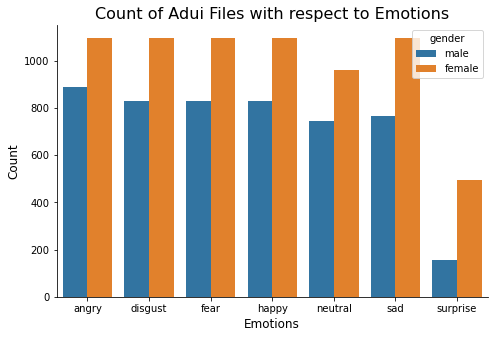

In [54]:
######################
# DATA VISUALIZATION #
######################
order = [ANGRY, DISGUST, FEAR, HAPPY, NEUTRAL, SAD, SURPRISE]

fig = plt.figure(figsize=(17, 5))

fig.add_subplot(121)
plt.title('Count of Adui Files with respect to Emotions', size=16)
sns.countplot(paths_df.emotion, order = order, hue=paths_df.gender)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.show()

In [72]:
def create_waveplot(path, label):
    data, sampling_rate = librosa.load(path)
    
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {label} emotion', size=15)
    librosa.display.waveplot(data, sr=sampling_rate)
    plt.show()
    
    display(ipd.Audio(path))

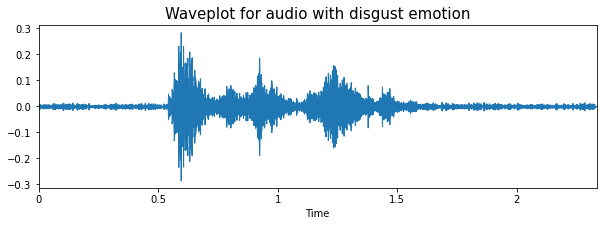

In [78]:
audio = paths_df.loc[1]
create_waveplot(audio['path'], audio['emotion'])

In [134]:
# create a dataframe with the features (mfccs) calculated

df = pd.DataFrame(columns=['feature'])

# The following block is commented out because the results of it are saved in a file 

# i = 0
# for filepath in tqdm(files_paths.filepath):
#     audio, sample_rate = librosa.load(filepath)
    
#     sample_rate = np.array(sample_rate)
#     mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#     mfccs_mean = np.mean(mfccs, axis=0)
#     df.loc[i] = [mfccs_mean]
    
#     i += 1

In [136]:
# saving the results of the last block in a file
# df.to_pickle('RAVDESS-mfccs')

In [5]:
# load the saved results from the file
df = pd.read_pickle('RAVDESS-mfccs')
df.head()

,feature
0,"[-21.432735, -21.432735, -21.432735, -21.43273..."
1,"[-21.622257, -21.622257, -21.622257, -21.62225..."
2,"[-18.101141, -17.714779, -16.729706, -17.67694..."
3,"[-19.077229, -19.447943, -19.401802, -18.92272..."
4,"[-20.582228, -19.17782, -18.60321, -19.964561,..."


In [312]:
# create one big dataframe containing the file paths, their labels and their features
df = pd.concat([files_paths, pd.DataFrame(df['feature'].values.tolist())], axis=1)

In [313]:
df

,filepath,label,0,1,2,3,4,5,6,7,...,218,219,220,221,222,223,224,225,226,227
0,data\Actor_01\03-01-01-01-01-01-01.wav,neutral,-21.432735,-21.432735,-21.432735,-21.432735,-21.432735,-21.432735,-21.432735,-21.277515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data\Actor_01\03-01-01-01-01-02-01.wav,neutral,-21.622257,-21.622257,-21.622257,-21.622257,-20.095755,-19.467009,-20.704380,-20.392015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data\Actor_01\03-01-01-01-02-01-01.wav,neutral,-18.101141,-17.714779,-16.729706,-17.676943,-18.284256,-17.920685,-18.152332,-17.445875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data\Actor_01\03-01-01-01-02-02-01.wav,neutral,-19.077229,-19.447943,-19.401802,-18.922726,-18.963850,-18.131964,-19.041887,-18.886808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data\Actor_01\03-01-02-01-01-01-01.wav,calm,-20.582228,-19.177820,-18.603210,-19.964561,-20.390726,-20.453844,-21.788517,-21.550198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,data\Actor_24\03-01-08-01-02-02-24.wav,surprised,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,data\Actor_24\03-01-08-02-01-01-24.wav,surprised,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,data\Actor_24\03-01-08-02-01-02-24.wav,surprised,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,data\Actor_24\03-01-08-02-02-01-24.wav,surprised,-17.836590,-17.836590,-17.836590,-17.836590,-17.836590,-17.824371,-17.803312,-17.827566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [314]:
# replace NaN by 0
df = df.fillna(0)
df

,filepath,label,0,1,2,3,4,5,6,7,...,218,219,220,221,222,223,224,225,226,227
0,data\Actor_01\03-01-01-01-01-01-01.wav,neutral,-21.432735,-21.432735,-21.432735,-21.432735,-21.432735,-21.432735,-21.432735,-21.277515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,data\Actor_01\03-01-01-01-01-02-01.wav,neutral,-21.622257,-21.622257,-21.622257,-21.622257,-20.095755,-19.467009,-20.704380,-20.392015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,data\Actor_01\03-01-01-01-02-01-01.wav,neutral,-18.101141,-17.714779,-16.729706,-17.676943,-18.284256,-17.920685,-18.152332,-17.445875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,data\Actor_01\03-01-01-01-02-02-01.wav,neutral,-19.077229,-19.447943,-19.401802,-18.922726,-18.963850,-18.131964,-19.041887,-18.886808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,data\Actor_01\03-01-02-01-01-01-01.wav,calm,-20.582228,-19.177820,-18.603210,-19.964561,-20.390726,-20.453844,-21.788517,-21.550198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,data\Actor_24\03-01-08-01-02-02-24.wav,surprised,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,-19.122814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,data\Actor_24\03-01-08-02-01-01-24.wav,surprised,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,data\Actor_24\03-01-08-02-01-02-24.wav,surprised,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,-18.535404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,data\Actor_24\03-01-08-02-02-01-24.wav,surprised,-17.836590,-17.836590,-17.836590,-17.836590,-17.836590,-17.824371,-17.803312,-17.827566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [315]:
# split the data: 80% train and 20% validation
X_train, X_test, y_train, y_test = train_test_split(df.drop(['filepath', 'label'], axis=1),
                                                   df['label'],
                                                   test_size=0.2,
                                                   shuffle=True,
                                                   random_state=42)

X_train[:10]

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
1148,-25.653189,-25.653189,-25.653189,-25.653189,-25.653189,-25.653189,-25.653189,-25.653189,-25.653189,-25.653189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
677,-16.186077,-16.186077,-16.186077,-16.186077,-16.186077,-16.186077,-16.186077,-16.186077,-16.186077,-16.186077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,-15.161586,-15.161586,-15.161586,-15.161586,-15.161586,-15.161586,-15.161586,-15.161586,-15.161586,-15.161586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,-19.642263,-19.642263,-19.642263,-19.642263,-19.642263,-19.642263,-19.642263,-19.642263,-19.642263,-19.642263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
845,-13.947101,-14.531044,-15.090982,-14.969928,-14.906607,-15.177971,-14.709198,-14.394396,-14.194595,-14.864087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1293,-16.140579,-16.444485,-16.444485,-16.302029,-16.444485,-16.444485,-16.444485,-15.763693,-15.243236,-16.430103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,-19.254173,-19.254173,-19.254173,-19.254173,-19.254173,-19.254173,-19.254173,-19.254173,-19.254173,-19.254173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
479,-14.281309,-14.782087,-15.179446,-14.877653,-15.576762,-15.649673,-14.376600,-13.651395,-13.175242,-13.773949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,-24.008503,-24.008503,-24.008503,-24.008503,-24.008503,-24.008503,-23.468340,-22.172907,-22.580055,-23.948896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,-18.309284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [316]:
# Normalizing the values
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

X_train[:10]

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
1148,-2.606499,-2.647716,-2.684357,-2.695999,-2.708532,-2.711116,-2.733128,-2.731972,-2.740366,-2.735461,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
677,0.452697,0.404067,0.400542,0.392150,0.388615,0.386758,0.372390,0.373810,0.373541,0.364191,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
221,0.783751,0.734318,0.734376,0.726337,0.723775,0.721997,0.708456,0.709905,0.710515,0.699622,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
113,-0.664133,-0.710056,-0.725671,-0.735250,-0.742070,-0.744192,-0.761351,-0.760027,-0.763262,-0.767408,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
845,1.176199,0.937577,0.757383,0.788855,0.807191,0.716636,0.856854,0.961589,1.028576,0.797027,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
1293,0.467399,0.320768,0.316338,0.354327,0.304078,0.302201,0.287624,0.512378,0.683659,0.284294,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
174,-0.538725,-0.584953,-0.599211,-0.608656,-0.615107,-0.617199,-0.634045,-0.632710,-0.635612,-0.640343,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
479,1.068203,0.856652,0.728556,0.818955,0.587951,0.562283,0.965957,1.205338,1.363860,1.153952,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
346,-2.075037,-2.117541,-2.148429,-2.159506,-2.170476,-2.172934,-2.016427,-1.590230,-1.729556,-2.177454,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476
1436,-0.233395,-0.280362,-0.291314,-0.300435,-0.305988,-0.308008,-0.324091,-0.322730,-0.324821,-0.330974,...,0.041458,0.041499,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476,0.029476


In [254]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [266]:
# mapping the labels into numbers: angry -> 0, calm -> 1, etc.
encoder = LabelEncoder()
encoder.fit(y_train)

# encoding the mapped values into vectors (one hot encoding), e.g.:
# 0 -> [1, 0, 0, 0, 0, 0, 0, 0]
# 1 -> [0, 1, 0, 0, 0, 0, 0, 0]
# 5 -> [0, 0, 0, 0, 0, 1, 0, 0]
y_train_encoded = tf.keras.utils.to_categorical(encoder.transform(y_train))
y_test_encoded = tf.keras.utils.to_categorical(encoder.transform(y_test))

print(encoder.classes_)
print(y_test)
print(y_test_encoded)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
['disgust' 'calm' 'calm' 'calm' 'angry' 'calm' 'calm' 'fearful'
 'surprised' 'calm' 'disgust' 'surprised' 'sad' 'fearful' 'sad' 'disgust'
 'angry' 'fearful' 'calm' 'disgust' 'surprised' 'neutral' 'neutral' 'sad'
 'fearful' 'sad' 'surprised' 'surprised' 'disgust' 'angry' 'surprised'
 'angry' 'happy' 'fearful' 'surprised' 'calm' 'disgust' 'angry' 'happy'
 'angry' 'calm' 'neutral' 'calm' 'angry' 'surprised' 'calm' 'calm'
 'neutral' 'fearful' 'sad' 'sad' 'surprised' 'surprised' 'angry' 'neutral'
 'calm' 'calm' 'surprised' 'happy' 'neutral' 'surprised' 'fearful'
 'surprised' 'surprised' 'fearful' 'happy' 'calm' 'disgust' 'disgust'
 'sad' 'happy' 'surprised' 'calm' 'happy' 'surprised' 'calm' 'angry'
 'surprised' 'sad' 'disgust' 'happy' 'happy' 'surprised' 'calm' 'happy'
 'angry' 'fearful' 'calm' 'happy' 'calm' 'neutral' 'calm' 'angry' 'angry'
 'neutral' 'disgust' 'surprised' 'happy' 'happy' 'surprised' 'disgust'
 'fearf

In [384]:
# creating the neural network model
model = tf.keras.Sequential()

# specifying the size of the input
model.add(Input(X_train.shape[1]))

model.add(Dense(units=128, activation ='relu', kernel_regularizer=tf.keras.regularizers.L2(0.02)))
model.add(Dense(units=64, activation ='relu', kernel_regularizer=tf.keras.regularizers.L2(0.02)))
model.add(Dense(units=8, activation ='softmax'))

model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 128)               29312     
_________________________________________________________________
dense_144 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_145 (Dense)            (None, 8)                 520       
Total params: 38,088
Trainable params: 38,088
Non-trainable params: 0
_________________________________________________________________


In [385]:
opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [386]:
history = model.fit(X_train, y_train_encoded, batch_size=16, epochs=100, validation_data=(X_test, y_test_encoded))

Epoch 1/100
72/72 [==============================] - 3s 12ms/step - loss: 6.3008 - accuracy: 0.2188 - val_loss: 4.6357 - val_accuracy: 0.3125
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 4.3138 - accuracy: 0.3419 - val_loss: 3.4665 - val_accuracy: 0.3438
Epoch 3/100
72/72 [==============================] - 0s 7ms/step - loss: 3.2799 - accuracy: 0.3821 - val_loss: 2.8233 - val_accuracy: 0.3438
Epoch 4/100
72/72 [==============================] - 0s 5ms/step - loss: 2.6399 - accuracy: 0.3940 - val_loss: 2.4650 - val_accuracy: 0.3507
Epoch 5/100
72/72 [==============================] - 0s 4ms/step - loss: 2.3282 - accuracy: 0.3850 - val_loss: 2.1925 - val_accuracy: 0.3472
Epoch 6/100
72/72 [==============================] - 0s 5ms/step - loss: 2.0928 - accuracy: 0.3978 - val_loss: 2.0814 - val_accuracy: 0.3438
Epoch 7/100
72/72 [==============================] - 0s 5ms/step - loss: 1.9983 - accuracy: 0.4007 - val_loss: 1.9873 - val_accuracy: 0.3576
Epoch 8/100
